# Fit the LDA model for the "Computation and Language" dataset

LDA yields 2 Dirichlet distributions:
1. Topics per text item (probabilities)
2. Words per topic

Implementation
1. Load the tokenized corpus created in 00_load_data
2. Fit the LDA model on the train corpus, evaluate it on the validate corpus
3. Save the fitted model


In [14]:
import gensim
from gensim import corpora
from gensim.parsing.preprocessing import preprocess_string
import pandas as pd
from matplotlib import pyplot as plt 
import pickle
import numpy as np
    
%matplotlib inline

## Load dictionary and corpus
Load the tokenized train- and validate-corpus created in 00_load_data.

In [2]:
with open('../data/dictionary_cscl.pickle', 'rb') as handle:
    dictionary_cscl = pickle.load(handle)

with open('../data/corpus_train_cscl.pickle', 'rb') as handle:
    corpus_train_cscl = pickle.load(handle)

with open('../data/corpus_validate_cscl.pickle', 'rb') as handle:
    corpus_validate_cscl = pickle.load(handle)

## Fit the LDA model
Fit the model on the training set, for different values of k.

Validate the model by computing perplexity for different values of k. The best value for k is that which yields a perplexity closest to 0.

Since LDA has a random component, the best k might vary between runs. Therefore the model is fitted several times and the best value is compiled from all runs (mode of best k for all runs).

see: https://radimrehurek.com/gensim/models/ldamodel.html

In [3]:
%%time

min_k = 2
max_k = 12
max_runs = 5
perplexity = []
for run in range(max_runs):
    print(f"Run {run + 1} / {max_runs}")
    px = []
    num_topics = []
    for k in range(min_k, max_k + min_k):
        # Define the LDA model
        ldamodel = gensim.models.ldamodel.LdaModel(corpus_train_cscl, num_topics=k, id2word=dictionary_cscl, passes=15)
        num_topics.append(k)
        px.append(ldamodel.log_perplexity(corpus_validate_cscl))
    perplexity.append(pd.DataFrame.from_dict({'k': num_topics, 'val': px}))

Run 1 / 5
Run 2 / 5
Run 3 / 5
Run 4 / 5
Run 5 / 5
CPU times: user 1h 16min 18s, sys: 196 ms, total: 1h 16min 18s
Wall time: 1h 16min 18s


_Following explanation generated by ChatGPT3.5_

### Perplexity in the Context of LDA

In the context of Latent Dirichlet Allocation (LDA), a popular topic modeling algorithm, 
**perplexity** is a measurement used to evaluate the goodness of fit of a statistical model. 
Specifically, in LDA, perplexity measures how well the model predicts a sample of unseen data.

#### Understanding Perplexity

1. **Definition**:
   - Perplexity is a measure of how well a probabilistic model predicts a set of data. 
     It is often used in natural language processing to evaluate language models.
   - Mathematically, it is the exponential of the average negative log-likelihood of a test set 
     under the model.

2. **In LDA**:
   - LDA is used to discover hidden topics in a collection of documents. It assumes that 
     documents are a mixture of topics and that topics are a mixture of words.
   - After training an LDA model on a training set, perplexity is used to assess the model’s 
     performance on a test set. A lower perplexity score indicates a better model because it 
     means the model is better at predicting the words in the test set.

#### Calculation of Perplexity

To calculate the perplexity of an LDA model on a set of documents, follow these steps:

1. **Estimate the Log-Likelihood**:
   - Compute the log-likelihood of the test set using the trained LDA model. The log-likelihood 
     measures how likely the model thinks the test data is, given the topics discovered during 
     training.

2. **Average Negative Log-Likelihood**:
   - Compute the average negative log-likelihood per word in the test set.

3. **Exponentiation**:
   - Take the exponential of the average negative log-likelihood to get the perplexity score.

Mathematically, perplexity $P(D)$ for a set of documents $D$ is given by:

$$ 
P(D) = \exp \left( -\frac{1}{N} \sum_{d \in D} \log p(w_d) \right) 
$$

where:
- $N$ is the total number of words in the test set.
- $w_d$ represents the words in document $d$.
- $p(w_d)$ is the probability of the words in $d$ given the LDA model.

#### Interpretation

- **Lower Perplexity**: Indicates the model is good at predicting the words in the test set, 
  suggesting a better fit to the data.
- **Higher Perplexity**: Indicates the model struggles to predict the words in the test set, 
  suggesting a worse fit to the data.

#### Use in Model Selection

When developing an LDA model, you might train multiple models with different numbers of topics 
or different hyperparameters. Perplexity is used to compare these models and select the one 
that best fits the data. However, it is important to note that perplexity is not the only 
metric for evaluating LDA models. Coherence scores and human interpretability of the topics 
are also important considerations.


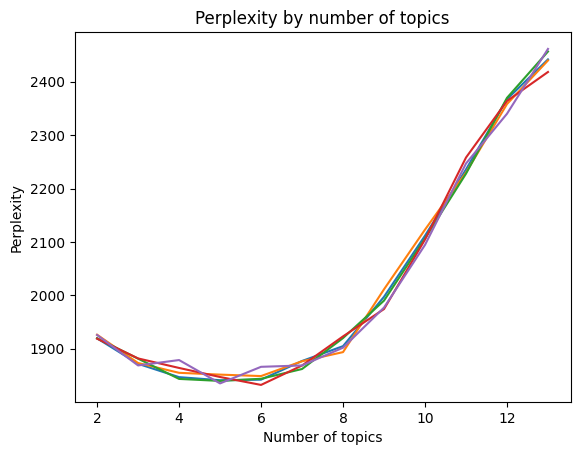

In [15]:
for run in range(max_runs):
    plt.plot(perplexity[run].k, np.exp(-perplexity[run].val))
plt.title("Perplexity by number of topics")
plt.xlabel("Number of topics")
plt.ylabel("Perplexity")
plt.show()

### Find the best k value: mode of list of best values for each run

In [16]:
import statistics

best_k_runs = []
for run in range(max_runs):
    best_k_runs.append(perplexity[run].sort_values('val', ascending=False).iloc[0]['k'])
best_k = statistics.mode(best_k_runs)
print(f"Best number of topics after {max_runs} runs is: {best_k}")

Best number of topics after 5 runs is: 5.0


## Refit the model, with best k

In [17]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus_train, num_topics=best_k, id2word=dictionary, passes=15)

Print the topics, with top words

In [18]:
topics = ldamodel.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.011*"data" + 0.010*"text" + 0.009*"research" + 0.008*"paper" + 0.008*"analysis"')
(1, '0.016*"question" + 0.014*"knowledge" + 0.014*"llm" + 0.013*"task" + 0.012*"human"')
(2, '0.025*"speech" + 0.015*"image" + 0.014*"attention" + 0.013*"network" + 0.010*"end"')
(3, '0.027*"word" + 0.013*"sentence" + 0.012*"representation" + 0.011*"semantic" + 0.011*"based"')
(4, '0.024*"task" + 0.018*"training" + 0.017*"data" + 0.013*"performance" + 0.012*"method"')


## Save the model

In [19]:
import pickle

with open('../models/lda_nlp.pickle', 'wb') as handle:
    pickle.dump(ldamodel, handle, protocol=pickle.HIGHEST_PROTOCOL)